<a href="https://colab.research.google.com/github/AndyT3/ieeeFraud-Detection/blob/master/ieeeFraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IEEE-CIS Fraud Detection for Vesta Corp

https://www.kaggle.com/c/ieee-fraud-detection

E-commerce is a growing sector as companies transition from brick and mortar to online platforms. Vesta guarantees these online transaction to give businesses zero fraud liability by monitoring global fraud patterns and trends across clients and industries. Annually Vesta handles over $18B in transactions. Incremental improvement in fraud detection can yield tremendous returns.

I chose this case as it complements my background in Marketing Operations at Hotels.com

# Summary




# Import required libraries

In [1]:
# Importing the libraries 

import os
import glob
from pathlib import Path
import zipfile
import gc

import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
from scipy.stats import boxcox

from ipywidgets import widgets, interactive
from ipykernel.pylab.backend_inline import flush_figures

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,precision_score,precision_recall_curve,f1_score,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

!pip install git+git://github.com/Hvass-Labs/scikit-optimize.git@dd7433da068b5a2509ef4ea4e5195458393e6555
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import itertools
from skopt import gp_minimize
   



  Cloning git://github.com/Hvass-Labs/scikit-optimize.git (to revision dd7433da068b5a2509ef4ea4e5195458393e6555) to /tmp/pip-req-build-a757x38p
  Running command git clone -q git://github.com/Hvass-Labs/scikit-optimize.git /tmp/pip-req-build-a757x38p
  Running command git checkout -q dd7433da068b5a2509ef4ea4e5195458393e6555
  Created wheel for scikit-optimize: filename=scikit_optimize-0.5-py2.py3-none-any.whl size=77763 sha256=d690ea1e7c10a41022c71af77ea04cd59a57b55e31bffd799278d637ed3b854c
  Stored in directory: /tmp/pip-ephem-wheel-cache-t_3b9lp_/wheels/e2/8b/7e/2956a87f1fb737a8c3f2ed18788b5e0ecfe4718141988c838f
Successfully built scikit-optimize


# Downloading Data From Kaggle

In [2]:
# Attaching Drive to colab and uploads the json api key for kaggle download
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andytran","key":"28c9b1c10fafa1fba3874d5a4516c73b"}'}

In [3]:
!pip install -q kaggle
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list
# !kaggle datasets list -s skin
!kaggle competitions download -c ieee-fraud-detection




-rw-r--r-- 1 root root 64 Jan 24 12:58 kaggle.json
 94% 49.0M/52.2M [00:00<00:00, 62.1MB/s]
100% 52.2M/52.2M [00:00<00:00, 132MB/s] 
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 109MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 210MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 78.0MB/s]
 70% 41.0M/58.3M [00:01<00:00, 30.4MB/s]
100% 58.3M/58.3M [00:01<00:00, 39.0MB/s]


In [0]:
# unzips the files downloaded from kaggle 
ls = glob.glob("*.zip") 
for item in ls:
  zipfile.ZipFile(item).extractall()

!rm *.zip

# Reading Data Files

In [0]:
#reading in the submissions files into a dataframe  
sample_submission = pd.read_csv('sample_submission.csv')
test_tran_df = pd.read_csv('test_transaction.csv')
test_identity_df = pd.read_csv('test_identity.csv')
train_tran_df = pd.read_csv('train_transaction.csv')
train_identity_df = pd.read_csv('train_identity.csv')




In [6]:
#Upon checking the column names, the test dataframe uses a - instead of a _. Matching the column names allow for processing test and train data frames simultaneously
print(test_identity_df.columns) 
print(train_identity_df.columns)
test_identity_df.columns = [x.strip().replace('-', '_') for x in test_identity_df.columns]
print(test_identity_df.columns)
print(train_identity_df.columns)

Index(['TransactionID', 'id-01', 'id-02', 'id-03', 'id-04', 'id-05', 'id-06',
       'id-07', 'id-08', 'id-09', 'id-10', 'id-11', 'id-12', 'id-13', 'id-14',
       'id-15', 'id-16', 'id-17', 'id-18', 'id-19', 'id-20', 'id-21', 'id-22',
       'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-28', 'id-29', 'id-30',
       'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')
Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')
Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'i

In [0]:
#Joining the transations and idenity tables 
train_df = pd.merge(train_tran_df, train_identity_df, on='TransactionID', how='left')
test_df = pd.merge(test_tran_df, test_identity_df, on='TransactionID', how='left')



In [20]:
train_df.head()



,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


# Exploratory Data Analysis 


In [8]:
#The data expected to have an inbalanced data due to the nature of fraud. 
#3.5 percent of transactions are frad
np.round(train_tran_df.isFraud.value_counts(normalize=True)*100,decimals=2)

SyntaxError: ignored

In [9]:
#Checking if there are any duplicate transactions 
# no duplicates
print("Unique Transaction ids: ",len(train_tran_df.TransactionID.unique()))
print("data dim: ",train_tran_df.shape)



Unique Transaction ids:  590540
data dim:  (590540, 394)


In [0]:
#ensure catagory features are set as catagories in the dataframe 
catCols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
           'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
           'id_26', 'id_27', 'id_28', 'id_29','id_30', 'id_31', 'id_32',
           'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
           'DeviceInfo', 'ProductCD','card1', 'card2', 'card3',  'card5', 'card4',
           'card6','P_emaildomain','R_emaildomain', 'addr1', 'addr2',
           'M1', 'M2', 'M3', 'M4','M5', 'M6', 'M7', 'M8', 'M9']

for x in catCols:
  train_df[x].astype('category')
  test_df[x].astype('category')




In [0]:
num_Columns_Card = ['card1','card2','card3','card4','card5','card6']
num_Columns_addr = ['addr1','addr2','dist1','P_emaildomain']
num_Columns_C = train_tran_df.loc[:, 'C1':'C14'].columns
num_Columns_D = train_tran_df.loc[:, 'D1':'D15'].columns
num_Columns_V = train_tran_df.loc[:, 'V1':'V321'].columns

In [28]:
df_card4

,card4,isFraud,counts
0,american express,0,8089
1,american express,1,239
2,discover,0,6137
3,discover,1,514
4,mastercard,0,182721
5,mastercard,1,6496
6,visa,0,371394
7,visa,1,13373


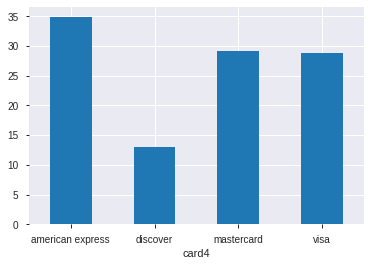

In [73]:
# determine if there is any releationship between card issuer and fraud
df_card4 = train_tran_df[['card4','isFraud']].groupby(['card4','isFraud']).size().reset_index(name='counts')
df_card4_plot = df_card4[['card4','counts']].groupby(['card4']).sum().counts  / df_card4[(df_card4['isFraud'] == 1)][['card4','counts']].groupby(['card4']).sum().counts
df_card4_plot.plot.bar(x='lab', y='val', rot=0)

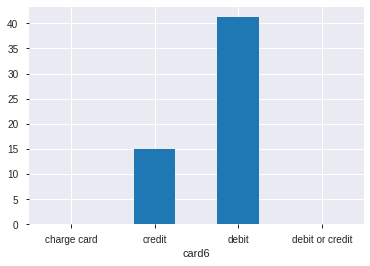

In [74]:
# determine if there is any releationship between card type and fraud 
df_card4 = train_tran_df[['card6','isFraud']].groupby(['card6','isFraud']).size().reset_index(name='counts')
df_card4_plot = df_card4[['card6','counts']].groupby(['card6']).sum().counts  / df_card4[(df_card6['isFraud'] == 1)][['card6','counts']].groupby(['card6']).sum().counts
df_card4_plot.plot.bar(x='lab', y='val', rot=0)

In [0]:
#it appears most of the fradualent transactions come from depit cards and amerian express cards 

In [0]:
# determine if there is any releationship between card issuer and type 
df_card = train_tran_df[['card4','card6','isFraud']].groupby(['card4','card6','isFraud']).size().reset_index(name='counts')
#df_card_plot = df_card.pivot

In [0]:
%time

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


# Feature Engineering

In [0]:
#feature engineering 
train_df['TransactionAmt_to_mean_card1'] = train_df['TransactionAmt'] / train_df.groupby(['card1'])['TransactionAmt'].transform('mean')
train_df['TransactionAmt_to_mean_card4'] = train_df['TransactionAmt'] / train_df.groupby(['card4'])['TransactionAmt'].transform('mean')
train_df['TransactionAmt_to_std_card1'] = train_df['TransactionAmt'] / train_df.groupby(['card1'])['TransactionAmt'].transform('std')
train_df['TransactionAmt_to_std_card4'] = train_df['TransactionAmt'] / train_df.groupby(['card4'])['TransactionAmt'].transform('std')

test_df['TransactionAmt_to_mean_card1'] = test_df['TransactionAmt'] / test_df.groupby(['card1'])['TransactionAmt'].transform('mean')
test_df['TransactionAmt_to_mean_card4'] = test_df['TransactionAmt'] / test_df.groupby(['card4'])['TransactionAmt'].transform('mean')
test_df['TransactionAmt_to_std_card1'] = test_df['TransactionAmt'] / test_df.groupby(['card1'])['TransactionAmt'].transform('std')
test_df['TransactionAmt_to_std_card4'] = test_df['TransactionAmt'] / test_df.groupby(['card4'])['TransactionAmt'].transform('std')

train_df['id_02_to_mean_card1'] = train_df['id_02'] / train_df.groupby(['card1'])['id_02'].transform('mean')
train_df['id_02_to_mean_card4'] = train_df['id_02'] / train_df.groupby(['card4'])['id_02'].transform('mean')
train_df['id_02_to_std_card1'] = train_df['id_02'] / train_df.groupby(['card1'])['id_02'].transform('std')
train_df['id_02_to_std_card4'] = train_df['id_02'] / train_df.groupby(['card4'])['id_02'].transform('std')

test_df['id_02_to_mean_card1'] = test_df['id_02'] / test_df.groupby(['card1'])['id_02'].transform('mean')
test_df['id_02_to_mean_card4'] = test_df['id_02'] / test_df.groupby(['card4'])['id_02'].transform('mean')
test_df['id_02_to_std_card1'] = test_df['id_02'] / test_df.groupby(['card1'])['id_02'].transform('std')
test_df['id_02_to_std_card4'] = test_df['id_02'] / test_df.groupby(['card4'])['id_02'].transform('std')


train_df['D15_to_mean_card1'] = train_df['D15'] / train_df.groupby(['card1'])['D15'].transform('mean')
train_df['D15_to_mean_card4'] = train_df['D15'] / train_df.groupby(['card4'])['D15'].transform('mean')
train_df['D15_to_std_card1'] = train_df['D15'] / train_df.groupby(['card1'])['D15'].transform('std')
train_df['D15_to_std_card4'] = train_df['D15'] / train_df.groupby(['card4'])['D15'].transform('std')

test_df['D15_to_mean_card1'] = test_df['D15'] / test_df.groupby(['card1'])['D15'].transform('mean')
test_df['D15_to_mean_card4'] = test_df['D15'] / test_df.groupby(['card4'])['D15'].transform('mean')
test_df['D15_to_std_card1'] = test_df['D15'] / test_df.groupby(['card1'])['D15'].transform('std')
test_df['D15_to_std_card4'] = test_df['D15'] / test_df.groupby(['card4'])['D15'].transform('std')

train_df['D15_to_mean_addr1'] = train_df['D15'] / train_df.groupby(['addr1'])['D15'].transform('mean')
train_df['D15_to_mean_addr2'] = train_df['D15'] / train_df.groupby(['addr2'])['D15'].transform('mean')
train_df['D15_to_std_addr1'] = train_df['D15'] / train_df.groupby(['addr1'])['D15'].transform('std')
train_df['D15_to_std_addr2'] = train_df['D15'] / train_df.groupby(['addr2'])['D15'].transform('std')

test_df['D15_to_mean_addr1'] = test_df['D15'] / test_df.groupby(['addr1'])['D15'].transform('mean')
test_df['D15_to_mean_addr2'] = test_df['D15'] / test_df.groupby(['addr2'])['D15'].transform('mean')
test_df['D15_to_std_addr1'] = test_df['D15'] / test_df.groupby(['addr1'])['D15'].transform('std')
test_df['D15_to_std_addr2'] = test_df['D15'] / test_df.groupby(['addr2'])['D15'].transform('std')



In [0]:
#combining similar device names and browers details 
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = 1

    return dataframe

In [0]:
train_df = id_split(train_df)
test_df = id_split(test_df)

In [0]:
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))

 - Dataset has 433338 (73.4%) duplicate rows	Warning
 - C1 is highly skewed (γ1 = 23.95795965)	Skewed
 - C10 is highly correlated with C1 (ρ = 0.9582021807)	Rejected
 - C11 is highly correlated with C10 (ρ = 0.9560557324)	Rejected
 - C12 is highly correlated with C11 (ρ = 0.9156926583)	Rejected
 - C13 has 35460 (6.0%) zeros	Zeros
 - C14 is highly correlated with C11 (ρ = 0.9624645831)	Rejected
 - C2 is highly correlated with C14 (ρ = 0.9361484959)	Rejected
 - C3 is highly skewed (γ1 = 88.94974565)	Skewed
 - C3 has 588111 (99.6%) zeros	Zeros
 - C4 is highly correlated with C2 (ρ = 0.9721337741)	Rejected
 - C5 has 372435 (63.1%) zeros	Zeros
 - C6 is highly correlated with C4 (ρ = 0.9623192744)	Rejected
 - C7 is highly correlated with C2 (ρ = 0.938867028)	Rejected
 - C8 is highly correlated with C7 (ρ = 0.9829833765)	Rejected
 - C9 is highly correlated with C5 (ρ = 0.9257858192)	Rejected
         

 - D1 has 280130 (47.4%) zeros	Zeros
 - D10 has 221930 (37.6%) zeros	Zeros
 - D10 has 76022 (12.9%) missing values	Missing
 - D11 has 112281 (19.0%) zeros	Zeros
 - D11 has 279287 (47.3%) missing values	Missing
 - D15 has 174246 (29.5%) zeros	Zeros
 - D15 has 89113 (15.1%) missing values	Missing
 - 'D2 is highly correlated with D1 (ρ = 0.981311391)	Rejected'
 - D3 has 73094 (12.4%) zeros	Zeros
 - D3 has 262878 (44.5%) missing values	Missing
 - D4 has 166571 (28.2%) zeros	Zeros
 - D4 has 168922 (28.6%) missing values	Missing
 - D5 has 65377 (11.1%) zeros	Zeros
 - D5 has 309841 (52.5%) missing values	Missing

In [0]:
#Dropping correlated features
correlated_cols = list(set(train_tran_df.loc[:, 'C1':'C14'].columns) - set(['C1','C13','C3','C5']))
train_df.drop(correlated_cols,axis = 1,inplace = True)
test_df.drop(correlated_cols,axis = 1,inplace = True)

train_df.drop(['D2'],axis = 1,inplace = True) 
test_df.drop(['D2'],axis = 1,inplace = True)

In [0]:
#Creating date time feature 
train_df['Transaction_dow'] = np.floor((train_df['TransactionDT'] / (3600 * 24)-1) % 7)#day of a week from some referance day
test_df['Transaction_dow'] = np.floor((test_df['TransactionDT'] / (3600 * 24)-1) % 7)#day of a week from some referance day
test_df['Transaction_hour'] = np.floor(test_df['TransactionDT'] / 3600) % 24 # hour of the day
train_df['Transaction_hour'] = np.floor(train_df['TransactionDT'] / 3600) % 24 # hour of the day

pd.crosstab(train_df['Transaction_dow'],train_df.isFraud).transpose()
pd.crosstab(train_df['Transaction_hour'],train_df.isFraud).transpose()

In [0]:
# New feature - log of transaction amount.
train_df['TransactionAmt_Log'] = np.log(train_df['TransactionAmt'])
test_df['TransactionAmt_Log'] = np.log(test_df['TransactionAmt'])


In [0]:
#Log transoformation and box cox transformation 
%matplotlib inline
plt.subplot(1, 3, 1)
(train_df.TransactionAmt).plot.hist(bins=50, figsize=(21, 5),color = 'red',alpha = 0.5 ,edgecolor = 'white', range = [0, 5000],title = 'Without Transformation')

plt.subplot(1, 3, 2)
pd.Series(boxcox(train_df.TransactionAmt)[0]).plot.hist(bins=50, figsize=(21,5),color = 'blue',alpha = 0.5 ,edgecolor='white',title = 'BoxCox Transformation')

plt.subplot(1, 3, 3)
np.log(train_df.TransactionAmt+1).plot.hist(bins=50, figsize=(21,5),color = 'blue',alpha = 0.5 ,edgecolor='white',title = 'log Transformation')

plt.show()

In [0]:
# New feature - decimal part of the transaction amount.
train_df['TransactionAmt_decimal'] = ((train_df['TransactionAmt'] - train_df['TransactionAmt'].astype(int)) * 1000).astype(int)
test_df['TransactionAmt_decimal'] = ((test_df['TransactionAmt'] - test_df['TransactionAmt'].astype(int)) * 1000).astype(int)

In [0]:
#Create test data for quick model validation
createActualModelData = 1 # set to 1 to actual model run

if createActualModelData == 0:
  X, y = load_iris(return_X_y=True)
  X = pd.DataFrame(X)
  y[y == 2] = 0
  y = pd.DataFrame(y)
  
if createActualModelData == 1:
#Preparing Data for modeling 
  X = train_df.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT','TransactionID'], axis=1).copy()
  y = train_df.sort_values('TransactionDT')['isFraud'].copy()
  X_test = test_df.drop(['TransactionDT','TransactionID'], axis=1).copy()

In [0]:
#splitting test and train 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

In [0]:
# random under sampling 
no_frauds = len(X_train[y_train == 0])
yes_frauds = len(X_train[y_train == 1])
non_fraud_indices = X_train[y_train == 0].index
random_indices = np.random.choice(non_fraud_indices, size = yes_frauds, replace=False)
fraud_indices =  X_train[y_train == 1].index
under_sample_indices = np.concatenate([fraud_indices,random_indices])

X_resampled = X_train.loc[under_sample_indices].copy()
y_resampled = y_train.loc[under_sample_indices].copy()

In [0]:
#run Logistic Regression, Decision tree, and random forest 

modelcompare = pd.DataFrame(columns=['Precision score','Recall score','Accuracy score','F1 score','AUC Score']
                             ,index =['LogisticRegression','DecisionTree', 'RandomForestClassifier','LGBM_SMOOT','LGBM','LGBM_Undersampling'])    
   
# logistic regression model
def ZlogRegression(X_train, X_test, y_train, y_test,df):
    c = .1
    logreg = LogisticRegression(class_weight='balanced',penalty='l1', C=c, solver='liblinear').fit(X_train.replace([np.inf, -np.inf, np.nan], 0), y_train)
    y_pred = logreg.predict(X_test.replace([np.inf, -np.inf, np.nan], 0))
    df.loc['LogisticRegression'] = pd.Series({'Precision score':precision_score(y_test,y_pred)
                                   , 'Recall score':recall_score(y_test,y_pred)
                                   , 'Accuracy score':accuracy_score(y_test,y_pred)
                                   , 'F1 score':f1_score(y_test,y_pred)
                                   , 'AUC Score':roc_auc_score(y_test,y_pred)})
    print('LogisticRegression')
    print(confusion_matrix(y_test, y_pred))
    print(df.loc['LogisticRegression'])
    return (df)

def Zdecisiontree(X_train, X_test, y_train, y_test,df):   
#decision tree model by tuning the proper parameters    
    opt_tree = DecisionTreeClassifier(random_state = 0)
    param_DT = {"max_depth": range(1,10),
               "min_samples_split": range(2,10,1),
               "max_leaf_nodes": range(2,5)}
    grid_tree = GridSearchCV(opt_tree,param_DT,cv=5)
    grid_tree.fit(X_train.replace([np.inf, -np.inf, np.nan], 0),y_train)
    print("The best decision tree parameters are " + str(grid_tree.best_params_)) #report the best parameters
    y_pred = grid_tree.predict(X_test.replace([np.inf, -np.inf, np.nan], 0))
    df.loc['DecisionTree'] = pd.Series({'Precision score':precision_score(y_test,y_pred)
                                   , 'Recall score':recall_score(y_test,y_pred)
                                   , 'Accuracy score':accuracy_score(y_test,y_pred)
                                   , 'F1 score':f1_score(y_test,y_pred)
                                   , 'AUC Score':roc_auc_score(y_test,y_pred)})
    print('DecisionTree')
    print(confusion_matrix(y_test, y_pred))  
    print(df.loc['DecisionTree']) 
    
#Use the same parameters to train a random forest model  
    rnd_clf = RandomForestClassifier(n_estimators=500,**grid_tree.best_params_, n_jobs=-1, random_state=42)
    rnd_clf.fit(X_train.replace([np.inf, -np.inf, np.nan], 0), y_train)
    y_pred = rnd_clf.predict(X_test.replace([np.inf, -np.inf, np.nan], 0))
    df.loc['RandomForestClassifier'] = pd.Series({'Precision score':precision_score(y_test,y_pred)
                                   , 'Recall score':recall_score(y_test,y_pred)
                                   , 'Accuracy score':accuracy_score(y_test,y_pred)
                                   , 'F1 score':f1_score(y_test,y_pred)
                                   , 'AUC Score':roc_auc_score(y_test,y_pred)})
    print('RandomForestClassifier')
    print(confusion_matrix(y_test, y_pred))  
    print(df.loc['RandomForestClassifier']) 
    
    return (df)


modelcompare = ZlogRegression(X_resampled, X_test, y_resampled, y_test, modelcompare)
modelcompare = Zdecisiontree(X_resampled, X_test, y_resampled, y_test, modelcompare)



LogisticRegression
[[118402  24012]
 [  1408   3813]]
Precision score    0.137035
Recall score        0.73032
Accuracy score     0.827819
F1 score           0.230769
AUC Score          0.780856
Name: LogisticRegression, dtype: object
The best decision tree parameters are {'max_depth': 3, 'max_leaf_nodes': 4, 'min_samples_split': 2}
DecisionTree
[[126325  16089]
 [  2514   2707]]
Precision score     0.14402
Recall score       0.518483
Accuracy score     0.873993
F1 score           0.225424
AUC Score          0.702755
Name: DecisionTree, dtype: object
RandomForestClassifier
[[115070  27344]
 [  1790   3431]]
Precision score    0.111487
Recall score       0.657154
Accuracy score     0.802662
F1 score           0.190632
AUC Score          0.732575
Name: RandomForestClassifier, dtype: object


In [0]:
#Standard Light GBM data prep
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=catCols, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=catCols, free_raw_data=False)

In [0]:
#hyper paramter optimization , Bayesian optimization using Gaussian Processes for light GBM
space  = [Integer(2, 100, name='max_depth'),
          Integer(6, 500, name='num_leaves'),
          Integer(50, 500, name='min_child_samples'),
          Real(1, 1000,  name='scale_pos_weight'),
          Real(0.0,1.0, name='min_child_weight'),
          Integer(50, 255, name='max_bin')
         ]

def objective(values):
    

    params = {'max_depth': values[0], 
             'num_leaves': values[1], 
             'min_child_samples': values[2], 
             'scale_pos_weight': values[3],
             'min_child_weight': values[4],
             'max_bin': values[5], 
             'metric':'auc',
             'boosting_type': 'gbdt',
             'objective': 'binary',
             'learning_rate':0.1,

             'application': 'binary',
             'objective': 'binary'}
    
    print('\n')
    print(params)
    
    evals_results = {}

    model_lgb     = lgb.train(params,
                              train_data,
                              valid_sets=[train_data, test_data],  
                              evals_result=evals_results, 
                              num_boost_round=300,
                              early_stopping_rounds=50,
                              verbose_eval=None, 
                              feval=None)
    
    auc = -roc_auc_score(y_test, model_lgb.predict(X_test[model_lgb.feature_name()]))
    print('AUC:',-auc,"iter:", model_lgb.current_iteration())
    gc.collect()

    return  auc


results_gp = gp_minimize(objective, 
                     space, 
                     n_calls=200,
                     random_state=0)

print("Optimal Score=%.7f" % results_gp.fun )
print("Best Parameters= " + str(results_gp.x) )






{'max_depth': 60, 'num_leaves': 423, 'min_child_samples': 436, 'scale_pos_weight': 847.4044870453415, 'min_child_weight': 0.6235636967859725, 'max_bin': 129, 'metric': 'auc', 'boosting_type': 'gbdt', 'objective': 'binary', 'learning_rate': 0.1, 'application': 'binary'}
AUC: 0.9668345117683189 iter: 246


{'max_depth': 31, 'num_leaves': 34, 'min_child_samples': 173, 'scale_pos_weight': 478.1874522040286, 'min_child_weight': 0.8121687287754934, 'max_bin': 148, 'metric': 'auc', 'boosting_type': 'gbdt', 'objective': 'binary', 'learning_rate': 0.1, 'application': 'binary'}
AUC: 0.9599503253806966 iter: 300


{'max_depth': 40, 'num_leaves': 419, 'min_child_samples': 202, 'scale_pos_weight': 648.5237001791461, 'min_child_weight': 0.368241539840548, 'max_bin': 246, 'metric': 'auc', 'boosting_type': 'gbdt', 'objective': 'binary', 'learning_rate': 0.1, 'application': 'binary'}
AUC: 0.9663468335048064 iter: 225


{'max_depth': 16, 'num_leaves': 436, 'min_child_samples': 263, 'scale_pos_weight':

In [0]:
#Optimal Score=-0.9752246
#Best Parameters= [36, 358, 500, 1.0, 1.0, 255]

In [0]:
#Light GBM model 

# parameters from hyper parameter optimization 
parameters = {'max_depth': results_gp.x[0], 
             'num_leaves': results_gp.x[1], 
             'min_child_samples': results_gp.x[2], 
             'scale_pos_weight': results_gp.x[3],
             'min_child_weight': results_gp.x[4],
             'max_bin': results_gp.x[5], 
             'metric':'auc',
             'boosting_type': 'gbdt',
             'objective': 'binary',
             'learning_rate':0.01,

             'application': 'binary',
             'objective': 'binary'}

# running light GBM model 
model = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=10000,
                       verbose_eval=500,
                       early_stopping_rounds=300)

# creating valid y preditions from confusion matrix and scores
y_pred = model.predict(X_test)
y_pred_valid = y_pred.copy()
y_pred_valid_class = y_pred.copy()
y_pred_valid_class[np.where(y_pred_valid>=.5)]=1
y_pred_valid_class[np.where(y_pred_valid<=.5)]=0

print('LGBM')
print(confusion_matrix(y_test, y_pred_valid_class))  

print({'Precision score':precision_score(y_test,y_pred_valid_class)
                                   , 'Recall score':recall_score(y_test,y_pred_valid_class)
                                   , 'Accuracy score':accuracy_score(y_test,y_pred_valid_class)
                                   , 'F1 score':f1_score(y_test,y_pred_valid_class)
                                   , 'AUC Score':roc_auc_score(y_test,y_pred)})


modelcompare.loc['LGBM'] = pd.Series({'Precision score':precision_score(y_test,y_pred_valid_class)
                                   , 'Recall score':recall_score(y_test,y_pred_valid_class)
                                   , 'Accuracy score':accuracy_score(y_test,y_pred_valid_class)
                                   , 'F1 score':f1_score(y_test,y_pred_valid_class)
                                   , 'AUC Score':roc_auc_score(y_test,y_pred)})




Training until validation scores don't improve for 300 rounds.
[500]	valid_0's auc: 0.966169
[1000]	valid_0's auc: 0.973627
[1500]	valid_0's auc: 0.975434
[2000]	valid_0's auc: 0.975955
Early stopping, best iteration is:
[2118]	valid_0's auc: 0.976007
LGBM
[[142300    114]
 [  1510   3711]]
{'Precision score': 0.9701960784313726, 'Recall score': 0.7107833748324076, 'Accuracy score': 0.9889998983980763, 'F1 score': 0.8204731372982534, 'AUC Score': 0.9760069745160059}


"\nTraining until validation scores don't improve for 300 rounds.\n[500]\tvalid_0's auc: 0.944726\n[1000]\tvalid_0's auc: 0.959432\n[1500]\tvalid_0's auc: 0.964588\n[2000]\tvalid_0's auc: 0.967016\n[2500]\tvalid_0's auc: 0.968289\n[3000]\tvalid_0's auc: 0.969039\n[3500]\tvalid_0's auc: 0.969531\n[4000]\tvalid_0's auc: 0.969834\n[4500]\tvalid_0's auc: 0.970127\n[5000]\tvalid_0's auc: 0.970428\n[5500]\tvalid_0's auc: 0.970671\n[6000]\tvalid_0's auc: 0.97084\n[6500]\tvalid_0's auc: 0.97091\n[7000]\tvalid_0's auc: 0.970973\nEarly stopping, best iteration is:\n[6865]\tvalid_0's auc: 0.970989\n----------------------------------\n"

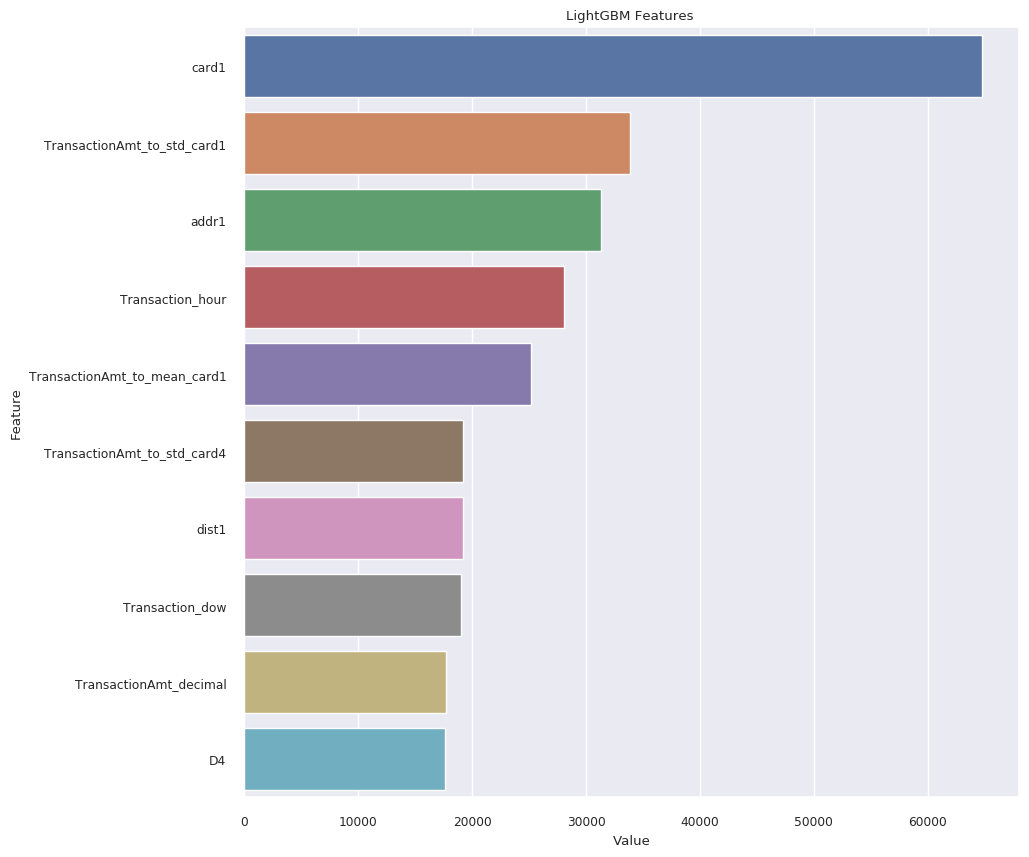

In [0]:
#Plot feature importiance for light GBM 
feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X_train.columns})
plt.figure(figsize=(10, 10))

sns.set(font_scale = 0.8)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:10])
plt.title('LightGBM Features ')
plt.savefig('lgbm_importances-01.png')
plt.show()


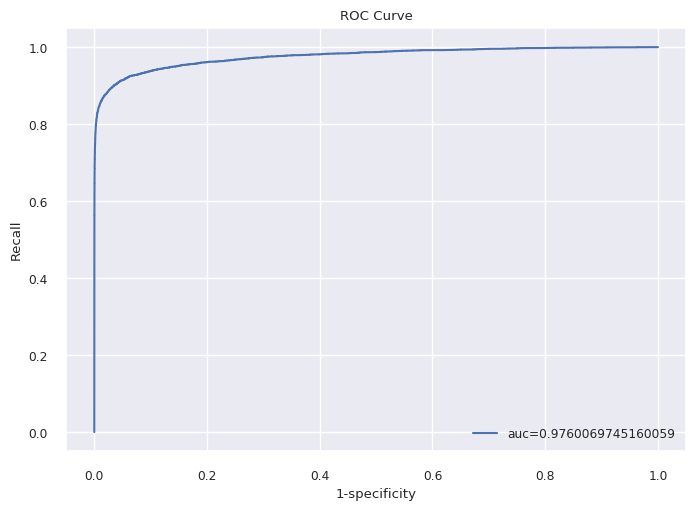

In [0]:
#ROC curve for Light GBM 
y_pred_proba = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.ylabel('Recall')
plt.xlabel('1-specificity')
plt.title('ROC Curve')
plt.show()

In [0]:
#Light GBM with under sampling 
train_data = lgb.Dataset(X_resampled, label=y_resampled, categorical_feature=catCols)
test_data = lgb.Dataset(X_test, label=y_test)




model_under = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=10000,
                       verbose_eval=500,
                       early_stopping_rounds=300)

y_pred = model_under.predict(X_test)
y_pred_valid = y_pred.copy()
y_pred_valid_class[np.where(y_pred_valid>=.5)]=1
y_pred_valid_class[np.where(y_pred_valid<=.5)]=0

print('LGBM_Undersampling')
print(confusion_matrix(y_test, y_pred_valid_class))  

print({'Precision score':precision_score(y_test,y_pred_valid_class)
                                   , 'Recall score':recall_score(y_test,y_pred_valid_class)
                                   , 'Accuracy score':accuracy_score(y_test,y_pred_valid_class)
                                   , 'F1 score':f1_score(y_test,y_pred_valid_class)
                                   , 'AUC Score':roc_auc_score(y_test,y_pred)})


modelcompare.loc['LGBM_Undersampling'] = pd.Series({'Precision score':precision_score(y_test,y_pred_valid_class)
                                   , 'Recall score':recall_score(y_test,y_pred_valid_class)
                                   , 'Accuracy score':accuracy_score(y_test,y_pred_valid_class)
                                   , 'F1 score':f1_score(y_test,y_pred_valid_class)
                                   , 'AUC Score':roc_auc_score(y_test,y_pred)})



Training until validation scores don't improve for 300 rounds.
[500]	valid_0's auc: 0.931458
[1000]	valid_0's auc: 0.945422
[1500]	valid_0's auc: 0.95169
[2000]	valid_0's auc: 0.955345
[2500]	valid_0's auc: 0.957544
[3000]	valid_0's auc: 0.959143
[3500]	valid_0's auc: 0.960227
[4000]	valid_0's auc: 0.961207
[4500]	valid_0's auc: 0.961794
[5000]	valid_0's auc: 0.962289
[5500]	valid_0's auc: 0.962707
[6000]	valid_0's auc: 0.962968
[6500]	valid_0's auc: 0.963278
[7000]	valid_0's auc: 0.963473
[7500]	valid_0's auc: 0.96364
[8000]	valid_0's auc: 0.963785
[8500]	valid_0's auc: 0.963961
[9000]	valid_0's auc: 0.964063
[9500]	valid_0's auc: 0.964168
[10000]	valid_0's auc: 0.964284
Did not meet early stopping. Best iteration is:
[9973]	valid_0's auc: 0.964285
LGBM_Undersampling
[[129567  12847]
 [   512   4709]]
{'Precision score': 0.26822738664843926, 'Recall score': 0.9019344953074123, 'Accuracy score': 0.9095133267856538, 'F1 score': 0.41348728980989585, 'AUC Score': 0.9642853898739111}


In [0]:
# print model results 
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
  print(modelcompare)
print ("The model with the highest precision score is " + str(modelcompare[modelcompare['Precision score'] == modelcompare['Precision score'].max()].index.values))
print ("The model with the highest recall score is " + str(modelcompare[modelcompare['Recall score'] == modelcompare['Recall score'].max()].index.values))
print ("The model with the highest accuracy score is " + str(modelcompare[modelcompare['Accuracy score'] == modelcompare['Accuracy score'].max()].index.values))
print ("The model with the highest F1 score is " + str(modelcompare[modelcompare['F1 score'] == modelcompare['F1 score'].max()].index.values))
print ("The model with the highest AUC score is " + str(modelcompare[modelcompare['AUC Score'] == modelcompare['AUC Score'].max()].index.values))



                       Precision score Recall score Accuracy score  F1 score  \
LogisticRegression            0.137035      0.73032       0.827819  0.230769   
DecisionTree                   0.14402     0.518483       0.873993  0.225424   
RandomForestClassifier        0.111487     0.657154       0.802662  0.190632   
LGBM_SMOOT                         NaN          NaN            NaN       NaN   
LGBM                          0.970196     0.710783          0.989  0.820473   
LGBM_Undersampling            0.268227     0.901934       0.909513  0.413487   

                       AUC Score  
LogisticRegression      0.780856  
DecisionTree            0.702755  
RandomForestClassifier  0.732575  
LGBM_SMOOT                   NaN  
LGBM                    0.976007  
LGBM_Undersampling      0.964285  
The model with the highest precision score is ['LGBM']
The model with the highest recall score is ['LGBM_Undersampling']
The model with the highest accuracy score is ['LGBM']
The model with the 

In [0]:
#create file for kaggle upload
submission = pd.DataFrame()
submission['TransactionID'] = test_df['TransactionID']
submission['isFraud'] = model.predict(test_df.drop(['TransactionDT','TransactionID'], axis=1))
submission.to_csv('ieee_cis_fraud_detection_v2.csv', index=False)


In [0]:
#submission to Kaggle 
!kaggle competitions submit ieee-fraud-detection -f ieee_cis_fraud_detection_v2.csv -m ""
 
